In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Import Data

source: http://www.bom.gov.au/climate/data/

In [3]:
df = pd.read_csv("data/daily_min_temp.csv", parse_dates=["Date"])
df['quarter'] = df.Date.dt.quarter
df = pd.get_dummies(df, columns=["quarter"])
df.set_index("Date", inplace=True)
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,20.7,1,0,0,0
1981-01-02,17.9,1,0,0,0
1981-01-03,18.8,1,0,0,0
1981-01-04,14.6,1,0,0,0
1981-01-05,15.8,1,0,0,0


### Scaling membantu RNN

In [4]:
df.Temp = df.Temp.transform(lambda x: (x-x.mean())/x.std())
df.head()

,Temp,quarter_1,quarter_2,quarter_3,quarter_4
Date,,,,,
1981-01-01,2.338563,1,0,0,0
1981-01-02,1.650913,1,0,0,0
1981-01-03,1.871943,1,0,0,0
1981-01-04,0.840467,1,0,0,0
1981-01-05,1.135175,1,0,0,0


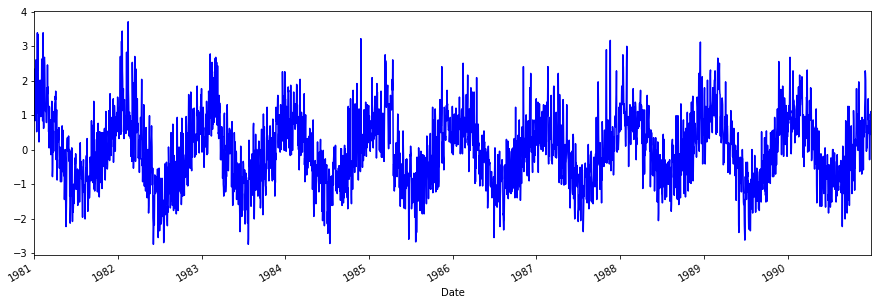

In [5]:
df.Temp.plot(figsize=(15, 5), color='b')

# Dataset Splitting

In [6]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 5), (730, 5))

# Prepare Sequence

In [7]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [8]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 5)
Note: last 7 data excluded

(N, S, F): (52, 14, 5)
Note: last 1 data excluded



In [9]:
5*14

70

# Arsitektur & Config

In [10]:
from jcopdl.layers import linear_block

In [11]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):        
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden

In [12]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation -> MCOC

In [13]:
model = GRU(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model/multivar')

# Training


Epoch     1
Train_cost  = 0.9266 | Test_cost  = 0.7994 | 

Epoch     2
Train_cost  = 0.7300 | Test_cost  = 0.5484 | 

Epoch     3
Train_cost  = 0.5573 | Test_cost  = 0.4643 | 

Epoch     4
Train_cost  = 0.5335 | Test_cost  = 0.4293 | 

Epoch     5
Train_cost  = 0.4966 | Test_cost  = 0.4369 | 
==> EarlyStop patience =  1 | Best test_cost: 0.4293

Epoch     6
Train_cost  = 0.4887 | Test_cost  = 0.4083 | 

Epoch     7
Train_cost  = 0.4702 | Test_cost  = 0.3901 | 

Epoch     8
Train_cost  = 0.4562 | Test_cost  = 0.3806 | 

Epoch     9
Train_cost  = 0.4430 | Test_cost  = 0.3727 | 

Epoch    10
Train_cost  = 0.4320 | Test_cost  = 0.3585 | 

Epoch    11
Train_cost  = 0.4194 | Test_cost  = 0.3457 | 

Epoch    12
Train_cost  = 0.4069 | Test_cost  = 0.3354 | 

Epoch    13
Train_cost  = 0.3954 | Test_cost  = 0.3248 | 

Epoch    14
Train_cost  = 0.3853 | Test_cost  = 0.3150 | 

Epoch    15
Train_cost  = 0.3775 | Test_cost  = 0.3092 | 

Epoch    16
Train_cost  = 0.3732 | Test_cost  = 0.3066 | 

Ep

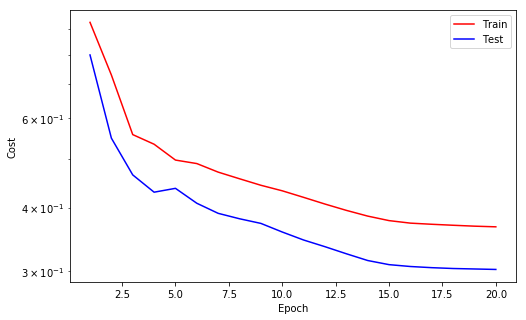


Epoch    21
Train_cost  = 0.3661 | Test_cost  = 0.3019 | 

Epoch    22
Train_cost  = 0.3651 | Test_cost  = 0.3013 | 

Epoch    23
Train_cost  = 0.3642 | Test_cost  = 0.3006 | 

Epoch    24
Train_cost  = 0.3634 | Test_cost  = 0.3000 | 

Epoch    25
Train_cost  = 0.3625 | Test_cost  = 0.2994 | 

Epoch    26
Train_cost  = 0.3617 | Test_cost  = 0.2989 | 

Epoch    27
Train_cost  = 0.3610 | Test_cost  = 0.2984 | 

Epoch    28
Train_cost  = 0.3603 | Test_cost  = 0.2979 | 

Epoch    29
Train_cost  = 0.3596 | Test_cost  = 0.2974 | 

Epoch    30
Train_cost  = 0.3589 | Test_cost  = 0.2970 | 

Epoch    31
Train_cost  = 0.3583 | Test_cost  = 0.2966 | 

Epoch    32
Train_cost  = 0.3578 | Test_cost  = 0.2962 | 

Epoch    33
Train_cost  = 0.3572 | Test_cost  = 0.2959 | 

Epoch    34
Train_cost  = 0.3567 | Test_cost  = 0.2955 | 

Epoch    35
Train_cost  = 0.3562 | Test_cost  = 0.2952 | 

Epoch    36
Train_cost  = 0.3558 | Test_cost  = 0.2949 | 

Epoch    37
Train_cost  = 0.3554 | Test_cost  = 0.2947 

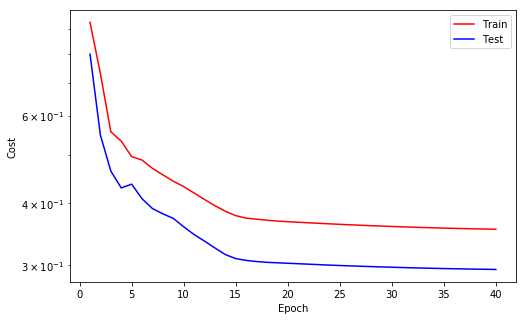


Epoch    41
Train_cost  = 0.3541 | Test_cost  = 0.2938 | 

Epoch    42
Train_cost  = 0.3538 | Test_cost  = 0.2936 | 

Epoch    43
Train_cost  = 0.3536 | Test_cost  = 0.2935 | 

Epoch    44
Train_cost  = 0.3534 | Test_cost  = 0.2933 | 

Epoch    45
Train_cost  = 0.3531 | Test_cost  = 0.2932 | 

Epoch    46
Train_cost  = 0.3529 | Test_cost  = 0.2931 | 

Epoch    47
Train_cost  = 0.3527 | Test_cost  = 0.2930 | 

Epoch    48
Train_cost  = 0.3525 | Test_cost  = 0.2930 | 

Epoch    49
Train_cost  = 0.3524 | Test_cost  = 0.2929 | 

Epoch    50
Train_cost  = 0.3522 | Test_cost  = 0.2929 | 

Epoch    51
Train_cost  = 0.3520 | Test_cost  = 0.2929 | 

Epoch    52
Train_cost  = 0.3518 | Test_cost  = 0.2928 | 

Epoch    53
Train_cost  = 0.3516 | Test_cost  = 0.2928 | 

Epoch    54
Train_cost  = 0.3515 | Test_cost  = 0.2928 | 
==> EarlyStop patience =  1 | Best test_cost: 0.2928

Epoch    55
Train_cost  = 0.3513 | Test_cost  = 0.2928 | 
==> EarlyStop patience =  2 | Best test_cost: 0.2928

Epoch   

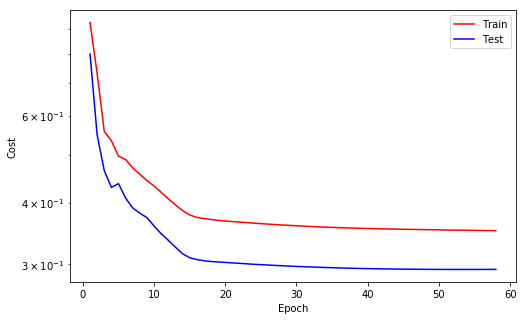

In [14]:
while True:    
    ## Training ##
    model.train()
    cost = 0
    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)

        output, hidden = model(inputs, None)
        loss = criterion(output, targets)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        hidden.detach_()

        cost += loss.item() * inputs.shape[0]
    train_cost = cost / len(train_set)
    
    ## Testing ##
    with torch.no_grad():
        model.eval()
        cost = 0
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)

            output, hidden = model(inputs, None)
            loss = criterion(output, targets)

            cost += loss.item() * inputs.shape[0]
        test_cost = cost / len(test_set)

    ## Callback ##
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()        
        break

# Load Best Model

In [15]:
weights = torch.load("model/multivar/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)

<All keys matched successfully>

# Forecast

In [16]:
from luwiji.rnn import illustration

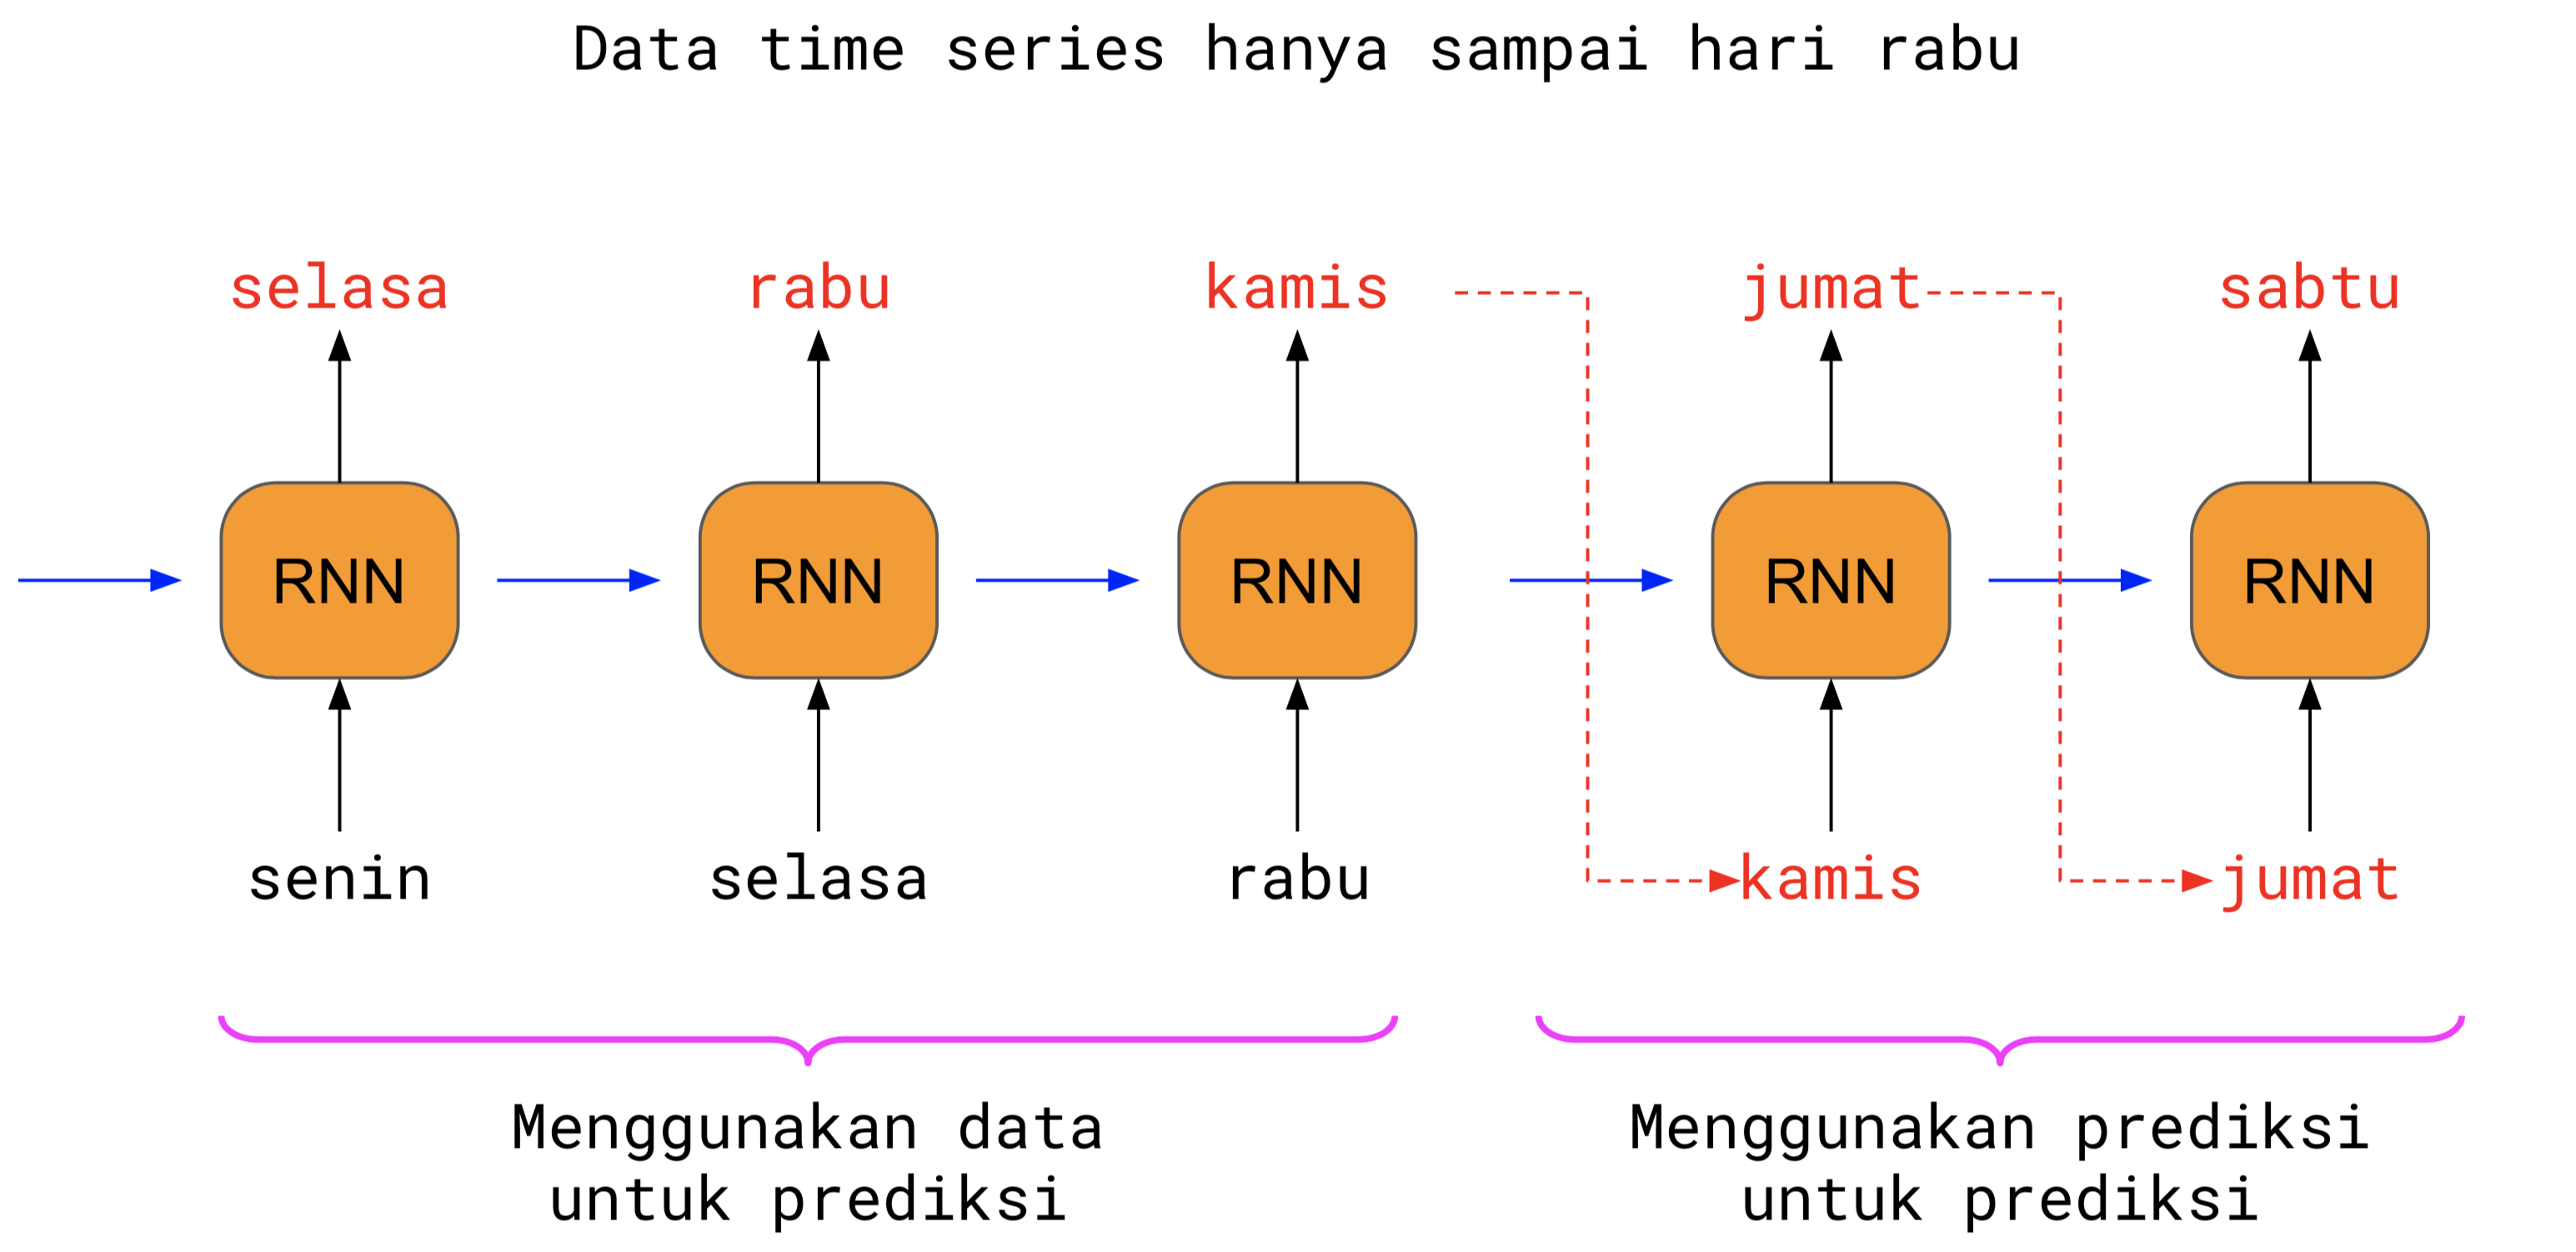

In [17]:
illustration.forecast

In [18]:
from utils import data4pred, pred4pred

In [19]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)

test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 5)
Note: last 0 data excluded

(N, S, F): (729, 1, 5)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

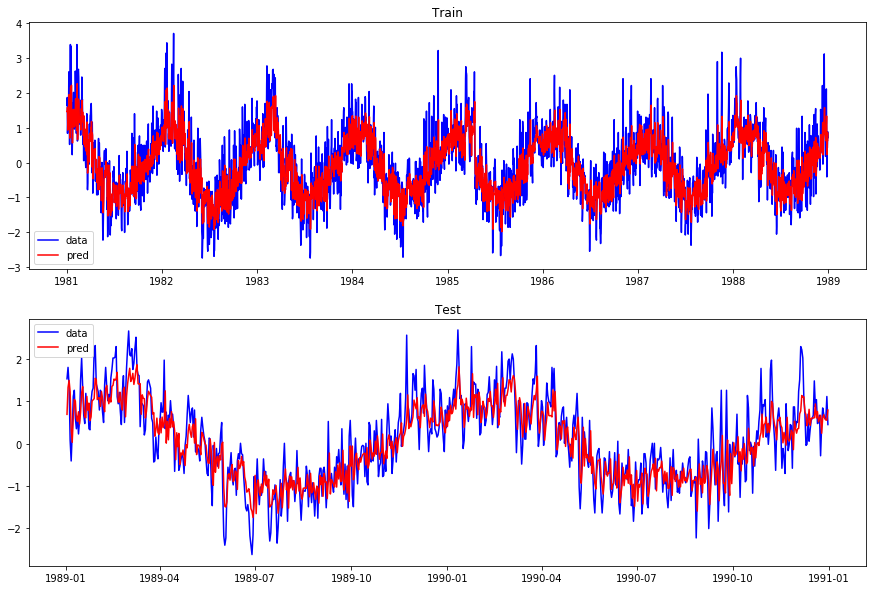

In [20]:
plt.figure(figsize=(15, 10))
    
plt.subplot(211)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

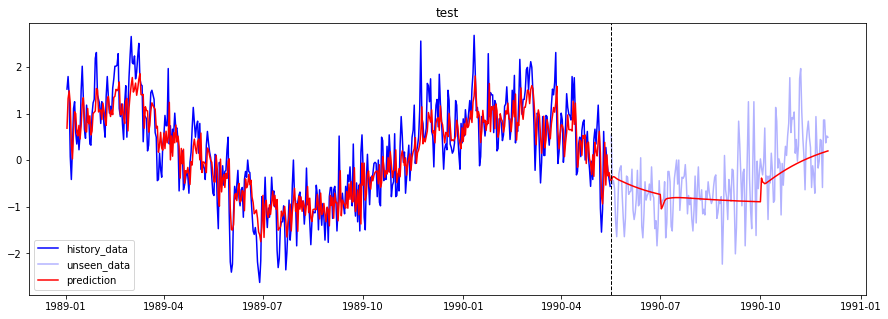

In [21]:
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test");

# More on RNN

In [22]:
from luwiji.rnn import illustration

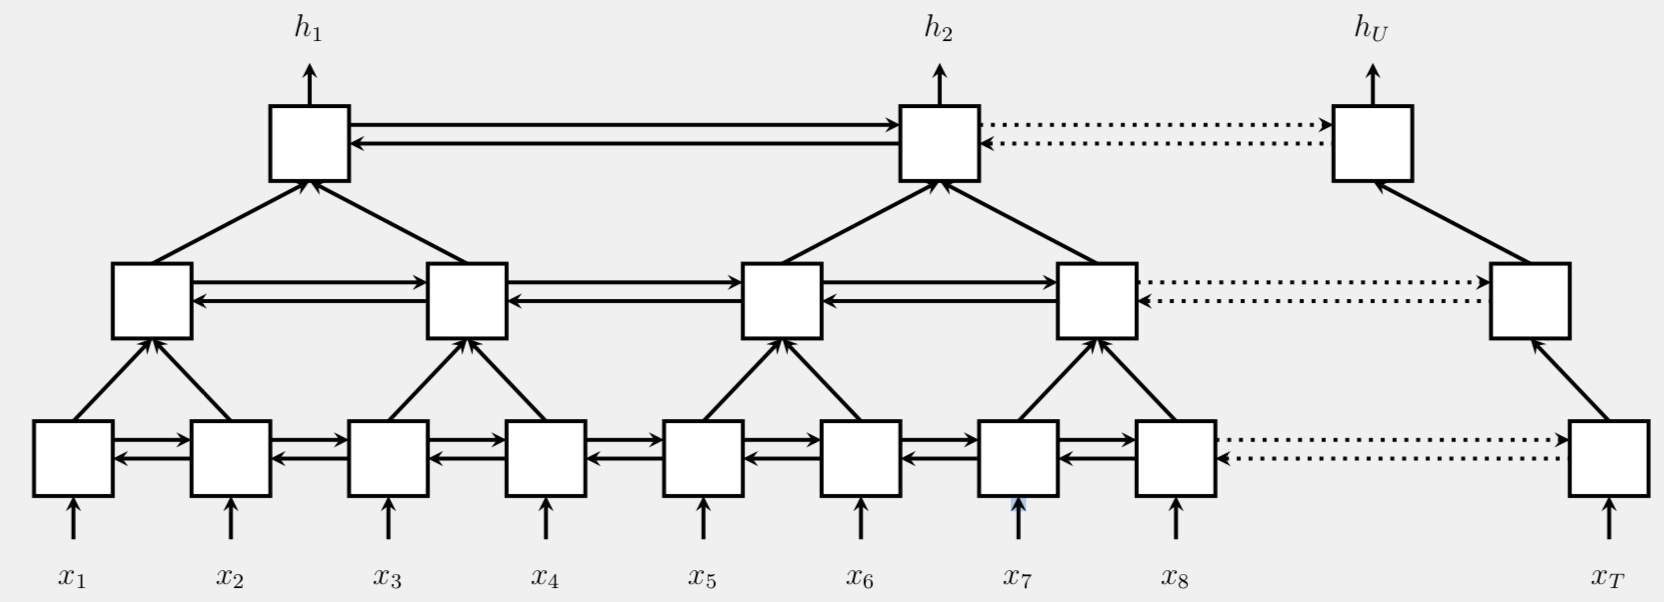

In [23]:
illustration.pyramid_blstm

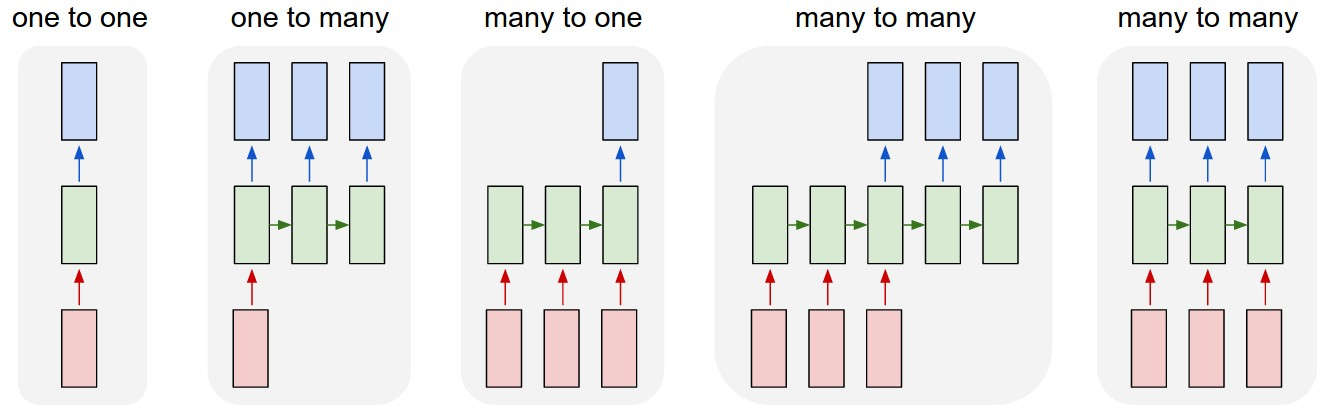

In [24]:
illustration.sequence_model

- one to one (fixed input and output): 
    - Image classification 
- one to many (fixed input and sequence output)
    - Image captioning
- many to one (sequence input and fixed output)
    - Sentiment analysis
- many to many (sequence input and sequence output)
    - machine translation
- synced many to many (sequence input and sequence output)
    - frame level video classification
    
Please check this out<br>
http://karpathy.github.io/2015/05/21/rnn-effectiveness/

RNN Midi Composer<br>
https://www.youtube.com/watch?v=0eTYs4n1LKg&t=2s